# Machine Learning in Python - MNIST Fashion With Feature Engineering

## Advanced Machine Learning UCD

**Name:** Briain O'Donnell

### Importing Modules

In [1]:
import os
import subprocess
from IPython.display import display, HTML, Image
import io
from operator import itemgetter

from TAS_Python_Utilities import data_viz
from TAS_Python_Utilities import data_viz_target
from TAS_Python_Utilities import visualize_tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
from scipy.misc import toimage

from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import neural_network

%matplotlib inline

### Data Setup 

In [2]:
# Set a data sampling rate for speeding up testing
data_sampling_rate = 0.1

# Setup the number of folds for all grid searches
cv_folds = 2

# Set up a dictionary to store simple model performance comparions
model_test_accuracy_comparisons = dict()
model_valid_accuracy_comparisons = dict()
model_tuned_params_list = dict()

### Load & Partition Data

**Part 3:** Load and explore the MNIST fashion training dataset

In [3]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) # take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
47838,6,0,0,0,0,0,0,2,66,124,...,42,10,0,0,4,0,0,0,0,0
21303,0,0,0,78,0,0,0,1,0,0,...,5,12,7,10,9,9,10,0,0,0
41675,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19985,2,0,0,0,0,1,0,0,0,0,...,0,0,0,108,123,80,0,0,0,0
51857,9,0,0,0,0,0,0,0,0,0,...,0,0,39,67,57,49,0,0,0,0


In [4]:
# Examine the distribution of the classes
dataset["label"].value_counts()

5    624
4    623
6    605
2    603
1    601
9    597
3    596
7    594
8    584
0    573
Name: label, dtype: int64

In [5]:
# Check for presence of missing values
print("Missing Values")
print(dataset.isnull().sum())

Missing Values
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
pixel6      0
pixel7      0
pixel8      0
pixel9      0
pixel10     0
pixel11     0
pixel12     0
pixel13     0
pixel14     0
pixel15     0
pixel16     0
pixel17     0
pixel18     0
pixel19     0
pixel20     0
pixel21     0
pixel22     0
pixel23     0
pixel24     0
pixel25     0
pixel26     0
pixel27     0
pixel28     0
pixel29     0
           ..
pixel755    0
pixel756    0
pixel757    0
pixel758    0
pixel759    0
pixel760    0
pixel761    0
pixel762    0
pixel763    0
pixel764    0
pixel765    0
pixel766    0
pixel767    0
pixel768    0
pixel769    0
pixel770    0
pixel771    0
pixel772    0
pixel773    0
pixel774    0
pixel775    0
pixel776    0
pixel777    0
pixel778    0
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


In [6]:
# Isolating the descriptive features we are interested in
X = dataset[dataset.columns[1:]]
Y = np.array(dataset["label"])

#### Displaying some of the images

[ 1158 ]  Sneaker


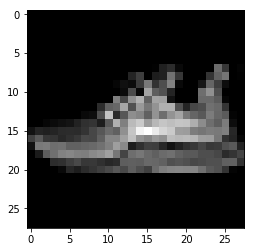

[ 1727 ]  Sandal


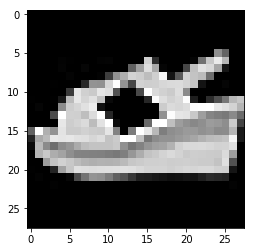

[ 2739 ]  Sneaker


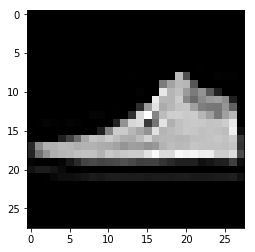

[ 1229 ]  Coat


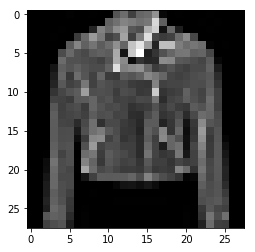

[ 4115 ]  Shirt


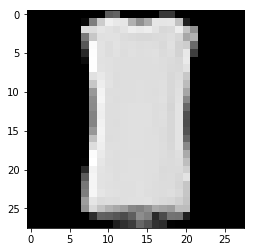

[ 500 ]  Trouser


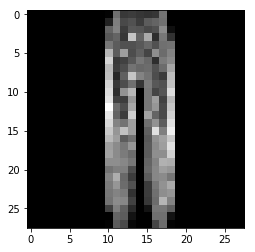

[ 4348 ]  Bag


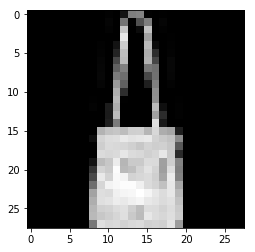

[ 260 ]  Bag


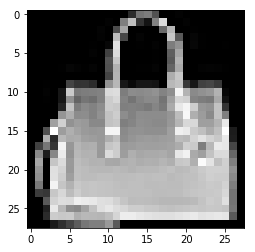

[ 2824 ]  Trouser


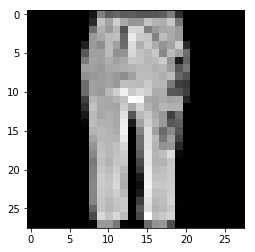

In [7]:
# Create a sample of images from the dataset
for i in range(0, 9):
    i_rand = randint(0, X.shape[0])

    print("[", i_rand, "] ", classes[Y[i_rand]])
    two_d = (X.iloc[i_rand].values.reshape(28, 28))
    pyplot.imshow(two_d, cmap='gray')
    pyplot.show()

In [8]:
# Normalise the data (this is important for some models)
X = X/255

In [9]:
# Extract some higher level features
engineered_features = pd.DataFrame()

# Calculate percentage of filled pixels and a top and bottom half only version
percent_filled = X.sum(axis = 1)/(28*28)
percent_filled_top = X.iloc[:, 0:392].sum(axis = 1)/(28*14)
percent_filled_bottom = X.iloc[:, 392:784].sum(axis = 1)/(28*14)
engineered_features['percent_filled'] = percent_filled
engineered_features['percent_filled_top'] = percent_filled_top
engineered_features['percent_filled_bottom'] = percent_filled_bottom

# Calculate the sum of each row
for idx, i in enumerate(range(0, 784, 28)):
    row_sum = X.iloc[:, i:(i + 28)].sum(axis = 1)/28
    engineered_features["row_sum_" + str(idx)] = row_sum

# Calcualte a measure of syymmetry around a horizontal axis
s1 = np.round(np.array(X.iloc[:, 0:392]))
s2 = np.round(np.array(X.iloc[:, 784:391:-1]))
s3 = np.logical_and(s1, s2).astype(int)
symmetry = s3.sum(axis = 1)/(28*28)

engineered_features['symmetry'] = symmetry

display(engineered_features.head(10))

X = engineered_features

,percent_filled,percent_filled_top,percent_filled_bottom,row_sum_0,row_sum_1,row_sum_2,row_sum_3,row_sum_4,row_sum_5,row_sum_6,...,row_sum_19,row_sum_20,row_sum_21,row_sum_22,row_sum_23,row_sum_24,row_sum_25,row_sum_26,row_sum_27,symmetry
47838,0.233944,0.243397,0.224490,0.133613,0.336695,0.233473,0.254902,0.251541,0.248880,0.246499,...,0.233473,0.243417,0.248179,0.255602,0.263585,0.260364,0.245938,0.209804,0.100700,0.008929
21303,0.210529,0.080512,0.340546,0.021989,0.057843,0.048039,0.035014,0.041036,0.041036,0.033613,...,0.366807,0.395518,0.422829,0.427031,0.444538,0.435294,0.284034,0.055462,0.028852,0.000000
41675,0.215931,0.141927,0.289936,0.000000,0.000000,0.000000,0.000000,0.082773,0.179692,0.047339,...,0.381513,0.356443,0.285994,0.725910,0.363585,0.029692,0.000000,0.000000,0.000000,0.029337
19985,0.398925,0.359634,0.438215,0.091597,0.147479,0.148459,0.315126,0.377591,0.396218,0.414706,...,0.476190,0.460924,0.461204,0.456162,0.455882,0.447059,0.462465,0.420448,0.085714,0.221939
51857,0.276501,0.234574,0.318427,0.067927,0.178711,0.186975,0.190196,0.213305,0.203501,0.220448,...,0.310504,0.371429,0.433193,0.355742,0.316527,0.357143,0.364006,0.314706,0.095658,0.058673
22353,0.154887,0.127351,0.182423,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067602
9769,0.255212,0.157303,0.353121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039076,...,0.783613,0.742717,0.520728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070153
48201,0.438185,0.379342,0.497029,0.136134,0.184174,0.233053,0.331092,0.416106,0.389496,0.403782,...,0.529692,0.510084,0.505042,0.509664,0.505182,0.607283,0.646779,0.457563,0.064566,0.261480
49790,0.173299,0.202721,0.143878,0.067227,0.161345,0.201261,0.225630,0.233473,0.235714,0.241877,...,0.136835,0.144818,0.147619,0.152941,0.164426,0.166387,0.161485,0.186695,0.129132,0.000000
25340,0.506007,0.548980,0.463035,0.079272,0.432073,0.583754,0.591877,0.628431,0.631092,0.646078,...,0.489636,0.486134,0.539916,0.645098,0.461345,0.433473,0.385014,0.347059,0.188235,0.211735


**Part 4:** Split the data into a **training dataset**, a **validation dataset**, and a **test dataset**

In [10]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X, Y, random_state=0, train_size = 0.7)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=0, train_size = 0.5/0.7)

### Building Simple Models

#### A Very Simple Decision Tree

**Part 5:** Train a decision tree

In [11]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy")
my_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Evaluating Model Performance

**Part 6:** Assess the performance of the decision tree on the **training dataset**

In [12]:
# Make a set of predictions for the training data
y_pred = my_tree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       288
           2       1.00      1.00      1.00       299
           3       1.00      1.00      1.00       301
           4       1.00      1.00      1.00       303
           5       1.00      1.00      1.00       306
           6       1.00      1.00      1.00       312
           7       1.00      1.00      1.00       303
           8       1.00      1.00      1.00       297
           9       1.00      1.00      1.00       306

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,285,0,0,0,0,0,0,0,0,0,285
1,0,288,0,0,0,0,0,0,0,0,288
2,0,0,299,0,0,0,0,0,0,0,299
3,0,0,0,301,0,0,0,0,0,0,301
4,0,0,0,0,303,0,0,0,0,0,303
5,0,0,0,0,0,306,0,0,0,0,306
6,0,0,0,0,0,0,312,0,0,0,312
7,0,0,0,0,0,0,0,303,0,0,303
8,0,0,0,0,0,0,0,0,297,0,297


Assess the performance of the tree on the **validation dataset**

In [13]:
# Make a set of predictions for the validation data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) 
model_valid_accuracy_comparisons["Simple Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.5808333333333333
              precision    recall  f1-score   support

           0       0.47      0.49      0.48       111
           1       0.84      0.84      0.84       129
           2       0.52      0.48      0.50       141
           3       0.45      0.46      0.45       107
           4       0.46      0.48      0.47       111
           5       0.71      0.58      0.64       127
           6       0.30      0.33      0.31       132
           7       0.70      0.72      0.71       114
           8       0.74      0.72      0.73       124
           9       0.68      0.74      0.71       104

    accuracy                           0.58      1200
   macro avg       0.59      0.58      0.58      1200
weighted avg       0.59      0.58      0.58      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,54,3,2,17,6,1,25,0,2,1,111
1,4,108,2,9,1,0,5,0,0,0,129
2,10,1,67,5,19,1,32,0,2,4,141
3,8,12,5,49,10,3,18,0,1,1,107
4,8,2,29,5,53,0,14,0,0,0,111
5,1,0,0,4,1,74,1,25,14,7,127
6,21,2,18,20,21,2,44,0,3,1,132
7,1,0,0,0,0,18,1,82,2,10,114
8,7,1,4,1,3,2,3,2,89,12,124


Assess the performance of the decision tree on the **test dataset**

In [14]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["Simple Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6011111111111112
              precision    recall  f1-score   support

           0       0.52      0.51      0.52       177
           1       0.82      0.82      0.82       184
           2       0.43      0.45      0.44       163
           3       0.47      0.49      0.48       188
           4       0.49      0.41      0.44       209
           5       0.74      0.65      0.69       191
           6       0.27      0.35      0.30       161
           7       0.79      0.78      0.79       177
           8       0.80      0.77      0.78       163
           9       0.78      0.78      0.78       187

    accuracy                           0.60      1800
   macro avg       0.61      0.60      0.60      1800
weighted avg       0.61      0.60      0.61      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,91,7,6,29,6,2,32,0,4,0,177
1,6,150,3,15,1,0,8,0,1,0,184
2,11,0,73,11,37,0,31,0,0,0,163
3,22,21,6,92,17,2,26,0,2,0,188
4,11,2,47,12,85,1,48,0,2,1,209
5,3,0,0,8,2,125,4,25,9,15,191
6,25,3,27,25,19,1,57,0,3,1,161
7,0,0,0,0,0,25,0,138,4,10,177
8,4,0,5,1,5,3,3,4,125,13,163


### Less Overiftted Decision Tree

Train a decision tree, setting min samples per leaf to a sensible value

In [15]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split = 200)
my_tree = my_tree.fit(X_train,y_train)

Assess the performance of the decision tree on the **training dataset**

In [16]:
# Make a set of predictions for the training data
y_pred = my_tree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6223333333333333
              precision    recall  f1-score   support

           0       0.75      0.33      0.46       285
           1       0.84      0.79      0.81       288
           2       0.44      0.43      0.44       299
           3       0.56      0.57      0.57       301
           4       0.47      0.68      0.56       303
           5       0.81      0.75      0.78       306
           6       0.29      0.31      0.30       312
           7       0.77      0.76      0.77       303
           8       0.85      0.75      0.80       297
           9       0.66      0.84      0.74       306

    accuracy                           0.62      3000
   macro avg       0.64      0.62      0.62      3000
weighted avg       0.64      0.62      0.62      3000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,94,4,49,35,16,2,75,2,7,1,285
1,4,228,0,33,0,0,23,0,0,0,288
2,1,1,130,5,109,0,37,0,3,13,299
3,8,32,7,173,18,0,56,1,4,2,301
4,1,3,31,22,206,0,21,0,6,13,303
5,0,0,1,7,0,230,9,40,3,16,306
6,17,4,62,22,88,1,96,3,11,8,312
7,0,0,0,0,0,24,0,230,0,49,303
8,0,1,7,4,1,9,7,14,223,31,297


Assess the performance of the decision tree on the **validation dataset**

In [17]:
# Make a set of predictions for the validation data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) 
model_valid_accuracy_comparisons["Better Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.5683333333333334
              precision    recall  f1-score   support

           0       0.62      0.28      0.39       111
           1       0.84      0.79      0.82       129
           2       0.52      0.47      0.49       141
           3       0.45      0.48      0.46       107
           4       0.41      0.67      0.51       111
           5       0.77      0.61      0.68       127
           6       0.21      0.22      0.22       132
           7       0.75      0.75      0.75       114
           8       0.76      0.69      0.73       124
           9       0.55      0.78      0.65       104

    accuracy                           0.57      1200
   macro avg       0.59      0.57      0.57      1200
weighted avg       0.59      0.57      0.57      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,31,2,18,16,7,0,31,0,3,3,111
1,0,102,1,13,0,0,13,0,0,0,129
2,1,1,66,5,42,0,21,0,3,2,141
3,8,11,4,51,8,0,18,0,4,3,107
4,0,2,10,7,74,0,11,0,1,6,111
5,0,0,1,3,0,77,3,19,2,22,127
6,10,3,19,15,45,4,29,0,6,1,132
7,0,0,0,0,0,12,0,85,0,17,114
8,0,0,5,2,2,3,8,6,86,12,124


Assess the performance of the decision tree on the **test dataset**

In [18]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["Better Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.5783333333333334
              precision    recall  f1-score   support

           0       0.70      0.31      0.43       177
           1       0.80      0.73      0.76       184
           2       0.40      0.45      0.42       163
           3       0.49      0.48      0.49       188
           4       0.52      0.67      0.59       209
           5       0.77      0.64      0.70       191
           6       0.20      0.25      0.22       161
           7       0.77      0.72      0.74       177
           8       0.79      0.70      0.74       163
           9       0.59      0.77      0.67       187

    accuracy                           0.58      1800
   macro avg       0.60      0.57      0.58      1800
weighted avg       0.61      0.58      0.58      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,55,3,39,25,7,1,42,0,5,0,177
1,0,135,4,24,1,0,20,0,0,0,184
2,1,1,73,5,56,0,23,0,2,2,163
3,6,20,11,90,11,0,40,0,8,2,188
4,4,3,19,11,140,0,22,0,1,9,209
5,0,2,0,5,0,123,8,29,2,22,191
6,13,5,28,16,48,0,40,0,4,7,161
7,0,0,0,0,0,14,0,127,0,36,177
8,0,0,6,2,4,7,3,3,114,24,163


## Choosing Parameters Using a Grid Search

**Part 7:** Use a grid search to tune the hyperparaemters for this model

In [19]:
my_tree = tree.DecisionTreeClassifier(max_depth = 12)
scores = cross_val_score(my_tree, X_train_plus_valid, y_train_plus_valid, cv=10)
print(scores)

[0.63915094 0.59338061 0.64539007 0.61611374 0.62380952 0.64285714
 0.61336516 0.65947242 0.63221154 0.60817308]


Here we try depths between 3 and 20 and different limits on the minimum number of samples per split.

In [20]:
# Set up the parameter grid to seaerch
param_grid ={'criterion': ['gini', "entropy"],
             'max_depth': list(range(3, 50, 3)),
             'min_samples_split': [200]}

# Perform the search
my_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv=cv_folds, verbose = 2, return_train_score=True)
my_tuned_tree.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
model_tuned_params_list["Tuned Tree"] = my_tuned_tree.best_params_
display(my_tuned_tree.best_score_)
display(my_tuned_tree.cv_results_)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=9, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_split=200 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=9, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=12, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=12, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=15, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=15, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=21, min_samples_split=200 .......

[CV]  criterion=entropy, max_depth=48, min_samples_split=200, total=   0.1s
Best parameters set found on development set:


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    4.7s finished


{'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 200}

0.5669047619047619

{'mean_fit_time': array([0.02598739, 0.03690124, 0.03789937, 0.0379138 , 0.036901  ,
        0.03872383, 0.03790915, 0.03690028, 0.03774297, 0.03689861,
        0.03692222, 0.03741956, 0.03739953, 0.03691411, 0.03790104,
        0.03839719, 0.07430375, 0.10425162, 0.10721147, 0.10658407,
        0.10333824, 0.10322368, 0.10754633, 0.10725665, 0.10723269,
        0.10718977, 0.10922933, 0.10721803, 0.10773253, 0.10771143,
        0.10771072, 0.10519683]),
 'std_fit_time': array([1.33514404e-05, 2.38418579e-07, 2.74181366e-06, 9.98735428e-04,
        9.98020172e-04, 8.36968422e-04, 9.95278358e-04, 9.98735428e-04,
        1.97291374e-04, 1.04141235e-03, 1.01947784e-03, 5.17606735e-04,
        4.97579575e-04, 1.00851059e-03, 9.91702080e-04, 1.49548054e-03,
        5.02467155e-04, 2.47168541e-03, 1.45065784e-03, 8.70466232e-04,
        5.78403473e-04, 1.49619579e-03, 2.15244293e-03, 1.45840645e-03,
        1.51622295e-03, 1.47640705e-03, 4.76121902e-04, 1.50156021e-03,
        1.97410583e-0

Evaluate the performance of the tuned tree

In [21]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["Tuned Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.5605555555555556
              precision    recall  f1-score   support

           0       0.53      0.52      0.52       177
           1       0.84      0.68      0.75       184
           2       0.35      0.50      0.41       163
           3       0.40      0.54      0.46       188
           4       0.53      0.34      0.42       209
           5       0.72      0.65      0.69       191
           6       0.28      0.29      0.28       161
           7       0.82      0.66      0.73       177
           8       0.75      0.69      0.72       163
           9       0.62      0.73      0.67       187

    accuracy                           0.56      1800
   macro avg       0.58      0.56      0.56      1800
weighted avg       0.59      0.56      0.57      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,92,5,30,33,2,0,8,0,3,4,177
1,3,125,7,45,0,0,3,0,0,1,184
2,15,1,82,9,21,0,35,0,0,0,163
3,13,15,29,102,5,0,10,0,1,13,188
4,17,3,37,24,72,0,53,0,2,1,209
5,0,0,1,11,0,125,1,18,11,24,191
6,30,0,30,28,20,0,46,0,2,5,161
7,0,0,0,0,0,31,0,117,13,16,177
8,0,0,6,4,6,6,3,5,112,21,163


## Comparing Models

**Part 8:** We can easily use the same patterns to train other types of models.

#### Random Forests

Train and evaluate a simple model 

In [22]:
# Do the same job with random forests
my_model = ensemble.RandomForestClassifier(n_estimators=300,  max_features = 3, min_samples_split=200)
my_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) 
model_valid_accuracy_comparisons["Random Forest"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.61
              precision    recall  f1-score   support

           0       0.58      0.43      0.49       111
           1       0.67      0.87      0.75       129
           2       0.61      0.42      0.50       141
           3       0.35      0.70      0.47       107
           4       0.43      0.63      0.51       111
           5       0.79      0.72      0.75       127
           6       0.30      0.02      0.04       132
           7       0.80      0.80      0.80       114
           8       0.81      0.79      0.80       124
           9       0.73      0.81      0.77       104

    accuracy                           0.61      1200
   macro avg       0.61      0.62      0.59      1200
weighted avg       0.61      0.61      0.58      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,48,19,8,29,2,0,2,0,3,0,111
1,1,112,1,14,1,0,0,0,0,0,129
2,3,15,59,26,33,0,1,0,4,0,141
3,8,10,2,75,8,0,1,0,3,0,107
4,2,2,8,26,70,0,3,0,0,0,111
5,0,0,0,5,1,92,0,14,2,13,127
6,20,10,14,33,41,5,3,0,6,0,132
7,0,0,0,0,0,16,0,91,0,7,114
8,1,0,4,3,1,2,0,4,98,11,124


Choose parameters using a grid search

In [24]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(100, 501, 50)), 'max_features': list(range(2, 10, 2)), 'min_samples_split': [200] }
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.RandomForestClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Random Forest"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] max_features=2, min_samples_split=200, n_estimators=100 .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=2, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] max_features=2, min_samples_split=200, n_estimators=100 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_features=2, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] max_features=2, min_samples_split=200, n_estimators=150 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=150, total=   0.4s
[CV] max_features=2, min_samples_split=200, n_estimators=150 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=150, total=   0.4s
[CV] max_features=2, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=200, total=   0.5s
[CV] max_features=2, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=200, total=   0.5s
[CV] max_features=2, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=250, total=   0.7s
[CV] max_features=2, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=250, total=   0.7s
[CV] max_features=2, min_samples_sp

[CV]  max_features=8, min_samples_split=200, n_estimators=150, total=   0.9s
[CV] max_features=8, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=200, total=   1.2s
[CV] max_features=8, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=200, total=   1.2s
[CV] max_features=8, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=250, total=   1.5s
[CV] max_features=8, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=250, total=   1.7s
[CV] max_features=8, min_samples_split=200, n_estimators=300 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=300, total=   1.8s
[CV] max_features=8, min_samples_split=200, n_estimators=300 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=300, total=   1.7s
[CV] max_features=8, min_samples_sp

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.5min finished


Best parameters set found on development set:
{'max_features': 6, 'min_samples_split': 200, 'n_estimators': 250}
0.5959523809523809


In [25]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred)
model_test_accuracy_comparisons["Tuned Random Forest"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6494444444444445
              precision    recall  f1-score   support

           0       0.73      0.59      0.65       177
           1       0.77      0.83      0.80       184
           2       0.46      0.54      0.50       163
           3       0.48      0.63      0.54       188
           4       0.54      0.60      0.57       209
           5       0.72      0.72      0.72       191
           6       0.39      0.24      0.30       161
           7       0.82      0.77      0.79       177
           8       0.85      0.79      0.82       163
           9       0.78      0.74      0.76       187

    accuracy                           0.65      1800
   macro avg       0.65      0.65      0.65      1800
weighted avg       0.65      0.65      0.65      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,104,11,15,28,3,3,9,0,4,0,177
1,1,152,2,25,0,0,4,0,0,0,184
2,1,6,88,12,41,0,15,0,0,0,163
3,9,24,9,119,10,0,11,0,6,0,188
4,0,2,41,22,125,0,16,0,3,0,209
5,0,1,1,10,0,138,0,23,2,16,191
6,26,2,28,23,39,0,39,0,3,1,161
7,0,0,0,0,0,30,0,136,1,10,177
8,0,0,4,1,5,8,0,4,129,12,163


#### Bagging

Train and evaluate a simple model 

In [26]:
# Do the same job with random forests
my_model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 50), n_estimators=10)
my_model.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=50,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),


In [27]:
# Make a set of predictions for the validation data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) 
model_valid_accuracy_comparisons["Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6208333333333333
              precision    recall  f1-score   support

           0       0.60      0.51      0.55       111
           1       0.82      0.87      0.84       129
           2       0.58      0.50      0.54       141
           3       0.46      0.54      0.50       107
           4       0.45      0.67      0.54       111
           5       0.73      0.71      0.72       127
           6       0.28      0.17      0.21       132
           7       0.75      0.77      0.76       114
           8       0.84      0.69      0.76       124
           9       0.68      0.83      0.74       104

    accuracy                           0.62      1200
   macro avg       0.62      0.63      0.62      1200
weighted avg       0.62      0.62      0.61      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,57,7,4,16,8,1,14,0,3,1,111
1,2,112,2,10,0,0,3,0,0,0,129
2,4,3,71,10,32,0,18,0,3,0,141
3,12,12,3,58,6,5,7,0,2,2,107
4,0,1,15,10,74,0,10,0,1,0,111
5,0,0,1,2,0,90,1,19,2,12,127
6,20,2,16,18,41,5,23,1,4,2,132
7,0,0,0,0,0,16,0,88,1,9,114
8,0,0,6,2,1,4,6,4,86,15,124


Choose parameters using a grid search

In [28]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
  'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.BaggingClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Bagging"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50, total=   1.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50, total=   1.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=300, total=   7.6s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=350 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.4min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'n_estimators': 350}
0.4076190476190476


In [29]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["Tuned Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.5544444444444444
              precision    recall  f1-score   support

           0       0.60      0.39      0.47       177
           1       0.60      0.86      0.71       184
           2       0.37      0.36      0.36       163
           3       0.37      0.35      0.36       188
           4       0.54      0.58      0.56       209
           5       0.63      0.70      0.66       191
           6       0.25      0.23      0.24       161
           7       0.79      0.77      0.78       177
           8       0.68      0.64      0.66       163
           9       0.68      0.61      0.64       187

    accuracy                           0.55      1800
   macro avg       0.55      0.55      0.54      1800
weighted avg       0.55      0.55      0.55      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,69,17,28,20,5,3,29,0,4,2,177
1,4,159,1,9,0,1,10,0,0,0,184
2,2,21,58,13,38,0,29,0,2,0,163
3,20,40,11,65,6,11,26,0,5,4,188
4,2,16,27,19,121,0,17,0,6,1,209
5,0,0,0,9,0,133,1,28,3,17,191
6,16,12,20,31,37,1,37,0,3,4,161
7,0,0,0,0,0,24,0,137,8,8,177
8,0,1,4,3,8,18,1,5,104,19,163


#### AdaBoost

Train and evaluate a simple model 

In [30]:
# Do the same job with random forests
my_model = ensemble.AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 200), n_estimators=10)
my_model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=200,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                     

In [31]:
# Make a set of predictions for the validation data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) 
model_valid_accuracy_comparisons["AdaBoost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.4533333333333333
              precision    recall  f1-score   support

           0       0.31      0.23      0.27       111
           1       0.93      0.51      0.66       129
           2       0.43      0.33      0.37       141
           3       0.31      0.58      0.40       107
           4       0.29      0.34      0.31       111
           5       0.67      0.46      0.54       127
           6       0.22      0.25      0.23       132
           7       0.52      0.81      0.63       114
           8       0.70      0.56      0.62       124
           9       0.61      0.52      0.56       104

    accuracy                           0.45      1200
   macro avg       0.50      0.46      0.46      1200
weighted avg       0.50      0.45      0.46      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,26,2,7,45,8,0,21,0,1,1,111
1,2,66,0,49,7,0,5,0,0,0,129
2,12,0,46,9,40,0,30,0,1,3,141
3,8,3,5,62,9,1,16,0,2,1,107
4,5,0,23,10,38,0,35,0,0,0,111
5,1,0,1,1,1,58,2,42,11,10,127
6,21,0,20,24,23,5,33,0,5,1,132
7,1,0,0,0,0,14,1,92,3,3,114
8,7,0,6,2,5,2,0,18,69,15,124


Choose parameters using a grid search

In [32]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
 'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.AdaBoostClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned AdaBoost"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50, total=   3.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=50, total=   3.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=300, total=  21.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), n_estimators=350 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.8min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'n_estimators': 500}
0.5852380952380952


In [33]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["Tuned AdaBoost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.59
              precision    recall  f1-score   support

           0       0.69      0.50      0.58       177
           1       0.88      0.81      0.84       184
           2       0.40      0.50      0.45       163
           3       0.56      0.61      0.58       188
           4       0.52      0.43      0.47       209
           5       0.68      0.51      0.58       191
           6       0.27      0.40      0.32       161
           7       0.54      0.81      0.65       177
           8       0.81      0.80      0.81       163
           9       0.87      0.55      0.68       187

    accuracy                           0.59      1800
   macro avg       0.62      0.59      0.60      1800
weighted avg       0.63      0.59      0.60      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,89,4,13,38,1,0,29,0,3,0,177
1,6,149,2,18,1,0,8,0,0,0,184
2,4,1,82,2,36,0,38,0,0,0,163
3,14,15,4,115,13,0,24,0,3,0,188
4,0,0,59,8,89,0,51,0,2,0,209
5,1,0,0,6,1,97,1,71,3,11,191
6,13,1,39,15,27,0,64,0,2,0,161
7,0,0,0,0,0,29,0,143,4,1,177
8,2,0,4,0,1,6,8,8,131,3,163


#### Logistic Regression

Train and evaluate a simple model 

In [34]:
# Do the same job with logistic regression
my_model = linear_model.LogisticRegression()
my_model.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) 
model_valid_accuracy_comparisons["Logistic Regression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.595
              precision    recall  f1-score   support

           0       0.60      0.50      0.55       111
           1       0.67      0.93      0.78       129
           2       0.49      0.44      0.46       141
           3       0.45      0.57      0.50       107
           4       0.38      0.41      0.39       111
           5       0.67      0.68      0.67       127
           6       0.37      0.17      0.24       132
           7       0.74      0.82      0.78       114
           8       0.77      0.71      0.74       124
           9       0.71      0.76      0.73       104

    accuracy                           0.59      1200
   macro avg       0.58      0.60      0.58      1200
weighted avg       0.58      0.59      0.58      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,56,23,2,18,2,4,5,0,1,0,111
1,0,120,3,5,0,0,1,0,0,0,129
2,6,14,62,11,32,4,10,0,2,0,141
3,10,8,13,61,2,4,4,0,5,0,107
4,0,5,27,9,46,2,11,0,11,0,111
5,0,0,0,6,0,86,1,21,0,13,127
6,21,10,11,15,35,10,23,0,5,2,132
7,0,0,0,0,0,13,0,93,0,8,114
8,1,0,3,9,4,4,2,3,88,10,124


Choose parameters using a grid search

In [36]:
# Set up the parameter grid to seaerch
param_grid = [
 {'multi_class': ['ovr'], 
 'C': [x / 10.0 for x in range(2, 21, 2)],
 'solver':['liblinear'],
  'max_iter':[1000]}
]

# Perform the search
my_tuned_model = GridSearchCV(linear_model.LogisticRegression(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Logistic Regression"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=1.0, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=1.0, max_iter=1000, multi_class=ovr, solver=liblinear, total=   0.1s
[CV] C=1.0, max_iter=1000, multi_cl

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.1s finished


Best parameters set found on development set:
{'C': 1.8, 'max_iter': 1000, 'multi_class': 'ovr', 'solver': 'liblinear'}
0.6171428571428571


In [37]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["Tuned Logistic Regression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6216666666666667
              precision    recall  f1-score   support

           0       0.73      0.63      0.67       177
           1       0.67      0.86      0.75       184
           2       0.46      0.59      0.52       163
           3       0.51      0.56      0.54       188
           4       0.59      0.44      0.50       209
           5       0.65      0.66      0.66       191
           6       0.35      0.32      0.33       161
           7       0.78      0.80      0.79       177
           8       0.72      0.66      0.69       163
           9       0.76      0.70      0.73       187

    accuracy                           0.62      1800
   macro avg       0.62      0.62      0.62      1800
weighted avg       0.62      0.62      0.62      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,111,24,12,16,2,3,5,0,4,0,177
1,3,158,4,18,0,0,1,0,0,0,184
2,3,12,96,5,26,2,15,0,4,0,163
3,15,22,12,105,1,6,20,0,7,0,188
4,0,9,47,14,92,5,31,0,11,0,209
5,0,0,2,11,0,127,2,31,3,15,191
6,21,12,27,19,23,4,51,0,3,1,161
7,0,0,0,0,0,24,0,142,1,10,177
8,0,0,1,9,13,12,3,4,107,14,163


#### Nearest Neighbour

Train and evaluate a simple model 

In [38]:
# Do the same job with random forests
my_model = neighbors.KNeighborsClassifier()
my_model = my_model.fit(X_train,y_train)

In [39]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) 
model_valid_accuracy_comparisons["kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6458333333333334
              precision    recall  f1-score   support

           0       0.54      0.56      0.55       111
           1       0.71      0.95      0.81       129
           2       0.53      0.49      0.51       141
           3       0.54      0.63      0.58       107
           4       0.46      0.54      0.50       111
           5       0.80      0.65      0.71       127
           6       0.51      0.33      0.40       132
           7       0.77      0.82      0.79       114
           8       0.90      0.74      0.81       124
           9       0.71      0.82      0.76       104

    accuracy                           0.65      1200
   macro avg       0.65      0.65      0.64      1200
weighted avg       0.65      0.65      0.64      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,62,21,6,12,2,1,6,0,1,0,111
1,2,122,1,4,0,0,0,0,0,0,129
2,5,8,69,6,37,1,11,0,1,3,141
3,11,13,4,67,4,0,7,0,0,1,107
4,1,2,26,10,60,0,11,0,0,1,111
5,3,0,0,3,1,82,3,19,5,11,127
6,27,6,18,15,20,1,43,0,2,0,132
7,0,0,0,0,0,14,0,93,0,7,114
8,3,0,3,5,4,3,0,2,92,12,124


Choose parameters using a grid search

In [40]:
# Set up the parameter grid to seaerch
param_grid = [
               {'n_neighbors': list(range(1, 50, 5))}
]

# Perform the search
my_tuned_model = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned kNN"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   0.2s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .................................... n_neighbors=1, total=   0.1s
[CV] n_neighbors=6 ...................................................
[CV] .................................... n_neighbors=6, total=   0.2s
[CV] n_neighbors=6 ...................................................
[CV] .................................... n_neighbors=6, total=   0.2s
[CV] n_neighbors=11 ..................................................
[CV] ................................... n_neighbors=11, total=   0.2s
[CV] n_neighbors=11 ..................................................
[CV] ................................... n_neighbors=11, total=   0.2s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.2s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.2s
[CV] n_neighbors=21 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.2s finished


In [41]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred)
model_test_accuracy_comparisons["Tuned kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6811111111111111
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       177
           1       0.72      0.91      0.80       184
           2       0.46      0.62      0.53       163
           3       0.56      0.64      0.60       188
           4       0.64      0.54      0.59       209
           5       0.77      0.66      0.71       191
           6       0.42      0.37      0.39       161
           7       0.82      0.83      0.82       177
           8       0.92      0.77      0.84       163
           9       0.81      0.80      0.81       187

    accuracy                           0.68      1800
   macro avg       0.69      0.68      0.68      1800
weighted avg       0.69      0.68      0.68      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,117,21,9,19,1,0,8,0,2,0,177
1,0,167,2,11,0,0,4,0,0,0,184
2,2,8,101,6,23,0,22,0,1,0,163
3,14,20,16,120,8,0,7,0,2,1,188
4,0,3,46,18,113,0,27,0,1,1,209
5,1,1,2,12,1,127,5,23,3,16,191
6,18,12,34,15,22,0,59,0,1,0,161
7,0,0,0,0,0,21,0,147,0,9,177
8,0,0,7,3,5,9,3,3,126,7,163


### Multi Layer Perceptron

Train and evaluate a simple model 

In [42]:
# Do the same job with random forests
my_model = neural_network.MLPClassifier(hidden_layer_sizes=(300, 100))
my_model = my_model.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [43]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) 
model_valid_accuracy_comparisons["MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6975
              precision    recall  f1-score   support

           0       0.65      0.66      0.65       111
           1       0.83      0.90      0.87       129
           2       0.59      0.63      0.61       141
           3       0.71      0.61      0.66       107
           4       0.51      0.55      0.53       111
           5       0.83      0.72      0.77       127
           6       0.48      0.42      0.45       132
           7       0.80      0.78      0.79       114
           8       0.89      0.81      0.85       124
           9       0.70      0.92      0.80       104

    accuracy                           0.70      1200
   macro avg       0.70      0.70      0.70      1200
weighted avg       0.70      0.70      0.70      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,73,5,4,10,3,0,15,0,1,0,111
1,1,116,3,4,0,0,5,0,0,0,129
2,7,1,89,1,24,0,14,1,2,2,141
3,7,13,6,65,3,1,9,0,1,2,107
4,0,2,25,5,61,0,16,0,1,1,111
5,1,0,0,2,0,92,0,15,4,13,127
6,20,2,18,3,28,2,56,1,2,0,132
7,0,0,0,0,0,12,0,89,1,12,114
8,3,0,5,1,0,3,0,1,100,11,124


Choose parameters using a grid search

In [44]:
# Set up the parameter grid to seaerch
param_grid = [
               {'hidden_layer_sizes': [(400), (400, 200), (400, 200, 100)], 
               'alpha': list(10.0 ** -np.arange(1, 7))}
]

# Perform the search
my_tuned_model = GridSearchCV(neural_network.MLPClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned MLP"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] alpha=0.1, hidden_layer_sizes=400 ...............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] ................ alpha=0.1, hidden_layer_sizes=400, total=   5.3s
[CV] alpha=0.1, hidden_layer_sizes=400 ...............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ................ alpha=0.1, hidden_layer_sizes=400, total=   5.3s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200) ........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ......... alpha=0.1, hidden_layer_sizes=(400, 200), total=  13.7s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200) ........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ......... alpha=0.1, hidden_layer_sizes=(400, 200), total=  13.6s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200, 100) ...................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .... alpha=0.1, hidden_layer_sizes=(400, 200, 100), total=  16.7s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200, 100) ...................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .... alpha=0.1, hidden_layer_sizes=(400, 200, 100), total=  17.0s
[CV] alpha=0.01, hidden_layer_sizes=400 ..............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............... alpha=0.01, hidden_layer_sizes=400, total=   5.2s
[CV] alpha=0.01, hidden_layer_sizes=400 ..............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............... alpha=0.01, hidden_layer_sizes=400, total=   5.3s
[CV] alpha=0.01, hidden_layer_sizes=(400, 200) .......................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ........ alpha=0.01, hidden_layer_sizes=(400, 200), total=  13.9s
[CV] alpha=0.01, hidden_layer_sizes=(400, 200) .......................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ........ alpha=0.01, hidden_layer_sizes=(400, 200), total=  14.1s
[CV] alpha=0.01, hidden_layer_sizes=(400, 200, 100) ..................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ... alpha=0.01, hidden_layer_sizes=(400, 200, 100), total=  16.9s
[CV] alpha=0.01, hidden_layer_sizes=(400, 200, 100) ..................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ... alpha=0.01, hidden_layer_sizes=(400, 200, 100), total=  16.7s
[CV] alpha=0.001, hidden_layer_sizes=400 .............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=0.001, hidden_layer_sizes=400, total=   5.2s
[CV] alpha=0.001, hidden_layer_sizes=400 .............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=0.001, hidden_layer_sizes=400, total=   5.4s
[CV] alpha=0.001, hidden_layer_sizes=(400, 200) ......................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....... alpha=0.001, hidden_layer_sizes=(400, 200), total=  14.0s
[CV] alpha=0.001, hidden_layer_sizes=(400, 200) ......................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....... alpha=0.001, hidden_layer_sizes=(400, 200), total=  13.8s
[CV] alpha=0.001, hidden_layer_sizes=(400, 200, 100) .................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. alpha=0.001, hidden_layer_sizes=(400, 200, 100), total=  16.9s
[CV] alpha=0.001, hidden_layer_sizes=(400, 200, 100) .................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. alpha=0.001, hidden_layer_sizes=(400, 200, 100), total=  16.5s
[CV] alpha=0.0001, hidden_layer_sizes=400 ............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............. alpha=0.0001, hidden_layer_sizes=400, total=   5.4s
[CV] alpha=0.0001, hidden_layer_sizes=400 ............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............. alpha=0.0001, hidden_layer_sizes=400, total=   5.4s
[CV] alpha=0.0001, hidden_layer_sizes=(400, 200) .....................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... alpha=0.0001, hidden_layer_sizes=(400, 200), total=  13.9s
[CV] alpha=0.0001, hidden_layer_sizes=(400, 200) .....................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... alpha=0.0001, hidden_layer_sizes=(400, 200), total=  13.9s
[CV] alpha=0.0001, hidden_layer_sizes=(400, 200, 100) ................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] . alpha=0.0001, hidden_layer_sizes=(400, 200, 100), total=  16.8s
[CV] alpha=0.0001, hidden_layer_sizes=(400, 200, 100) ................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] . alpha=0.0001, hidden_layer_sizes=(400, 200, 100), total=  17.0s
[CV] alpha=1e-05, hidden_layer_sizes=400 .............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=1e-05, hidden_layer_sizes=400, total=   5.2s
[CV] alpha=1e-05, hidden_layer_sizes=400 .............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=1e-05, hidden_layer_sizes=400, total=   5.4s
[CV] alpha=1e-05, hidden_layer_sizes=(400, 200) ......................
[CV] ....... alpha=1e-05, hidden_layer_sizes=(400, 200), total=  12.0s
[CV] alpha=1e-05, hidden_layer_sizes=(400, 200) ......................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....... alpha=1e-05, hidden_layer_sizes=(400, 200), total=  13.8s
[CV] alpha=1e-05, hidden_layer_sizes=(400, 200, 100) .................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. alpha=1e-05, hidden_layer_sizes=(400, 200, 100), total=  17.3s
[CV] alpha=1e-05, hidden_layer_sizes=(400, 200, 100) .................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. alpha=1e-05, hidden_layer_sizes=(400, 200, 100), total=  17.1s
[CV] alpha=1e-06, hidden_layer_sizes=400 .............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=1e-06, hidden_layer_sizes=400, total=   5.2s
[CV] alpha=1e-06, hidden_layer_sizes=400 .............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=1e-06, hidden_layer_sizes=400, total=   5.3s
[CV] alpha=1e-06, hidden_layer_sizes=(400, 200) ......................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....... alpha=1e-06, hidden_layer_sizes=(400, 200), total=  13.7s
[CV] alpha=1e-06, hidden_layer_sizes=(400, 200) ......................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....... alpha=1e-06, hidden_layer_sizes=(400, 200), total=  13.7s
[CV] alpha=1e-06, hidden_layer_sizes=(400, 200, 100) .................
[CV] .. alpha=1e-06, hidden_layer_sizes=(400, 200, 100), total=  14.6s
[CV] alpha=1e-06, hidden_layer_sizes=(400, 200, 100) .................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  7.1min finished


[CV] .. alpha=1e-06, hidden_layer_sizes=(400, 200, 100), total=  16.7s
Best parameters set found on development set:
{'alpha': 1e-06, 'hidden_layer_sizes': (400, 200, 100)}
0.7166666666666667


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [45]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["Tuned MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7288888888888889
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       177
           1       0.91      0.89      0.90       184
           2       0.50      0.66      0.57       163
           3       0.70      0.72      0.71       188
           4       0.65      0.66      0.65       209
           5       0.82      0.76      0.79       191
           6       0.47      0.42      0.44       161
           7       0.85      0.85      0.85       177
           8       0.85      0.82      0.83       163
           9       0.81      0.86      0.83       187

    accuracy                           0.73      1800
   macro avg       0.73      0.73      0.73      1800
weighted avg       0.74      0.73      0.73      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,108,2,18,14,2,0,30,0,3,0,177
1,2,164,1,12,4,0,1,0,0,0,184
2,1,2,108,4,33,0,13,0,1,1,163
3,13,9,6,135,7,0,10,0,6,2,188
4,0,1,38,12,138,1,17,0,1,1,209
5,1,0,1,4,0,146,0,21,4,14,191
6,15,3,35,10,26,0,68,0,3,1,161
7,0,0,0,0,0,15,0,151,0,11,177
8,0,0,6,0,3,6,4,3,133,8,163


### Compare Results

In [46]:
display(model_test_accuracy_comparisons)

{'Simple Tree': 0.6011111111111112,
 'Better Tree': 0.5783333333333334,
 'Tuned Tree': 0.5605555555555556,
 'Tuned Random Forest': 0.6494444444444445,
 'Tuned Bagging': 0.5544444444444444,
 'Tuned AdaBoost': 0.59,
 'Tuned Logistic Regression': 0.6216666666666667,
 'Tuned kNN': 0.6811111111111111,
 'Tuned MLP': 0.7288888888888889}

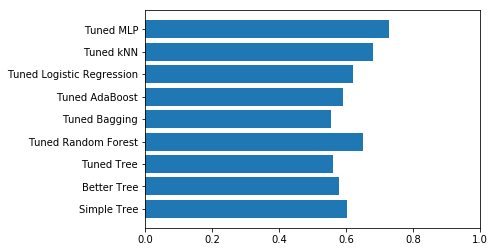

In [47]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))

In [48]:
display(model_valid_accuracy_comparisons)

{'Simple Tree': 0.5808333333333333,
 'Better Tree': 0.5683333333333334,
 'Random Forest': 0.61,
 'Bagging': 0.6208333333333333,
 'AdaBoost': 0.4533333333333333,
 'Logistic Regression': 0.595,
 'kNN': 0.6458333333333334,
 'MLP': 0.6975}

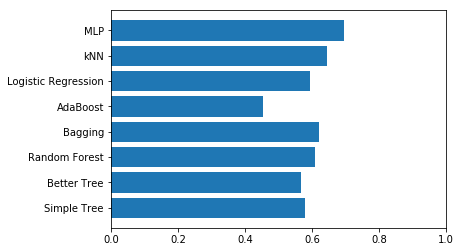

In [49]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.values()), align='center')
_= plt.yticks(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.keys()))

### Test Best Model On Test Dataset

In [50]:
test_dataset = pd.read_csv('fashion-mnist_test.csv')
test_dataset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# Isolating the descriptive features we are interested in
test_X = test_dataset[test_dataset.columns[1:]]
test_Y = np.array(test_dataset["label"])

In [52]:
# Normalise the data (this is important for some models)
test_X = test_X/255

In [53]:
# Extract some higher level features
engineered_features_test = pd.DataFrame()

# Calcualte percentage of filled pixels and a top and bottom half only version
percent_filled = test_X.sum(axis = 1)/(28*28)
percent_filled_top = test_X.iloc[:, 0:392].sum(axis = 1)/(28*14)
percent_filled_bottom = test_X.iloc[:, 392:784].sum(axis = 1)/(28*14)
engineered_features_test['percent_filled'] = percent_filled
engineered_features_test['percent_filled_top'] = percent_filled_top
engineered_features_test['percent_filled_bottom'] = percent_filled_bottom

# Calculate the sum of each row
for idx, i in enumerate(range(0, 784, 28)):
    row_sum = test_X.iloc[:, i:(i + 28)].sum(axis = 1)/28
    engineered_features_test["row_sum_" + str(idx)] = row_sum

# Calcualte a measure of syymmetry around a horizontal axis
s1 = np.round(np.array(test_X.iloc[:, 0:392]))
s2 = np.round(np.array(test_X.iloc[:, 784:391:-1]))
s3 = np.logical_and(s1, s2).astype(int)
symmetry = s3.sum(axis = 1)/(28*28)

engineered_features_test['symmetry'] = symmetry

display(engineered_features_test.head(10))

test_X = engineered_features_test

,percent_filled,percent_filled_top,percent_filled_bottom,row_sum_0,row_sum_1,row_sum_2,row_sum_3,row_sum_4,row_sum_5,row_sum_6,...,row_sum_19,row_sum_20,row_sum_21,row_sum_22,row_sum_23,row_sum_24,row_sum_25,row_sum_26,row_sum_27,symmetry
0,0.399620,0.422389,0.376851,0.018347,0.078992,0.185994,0.414286,0.550840,0.540196,0.518347,...,0.388235,0.391737,0.395098,0.395938,0.400560,0.393697,0.370728,0.457843,0.212745,0.161990
1,0.210664,0.236134,0.185194,0.209664,0.250000,0.267647,0.291877,0.267787,0.248880,0.240756,...,0.199160,0.201821,0.199860,0.202941,0.198039,0.191317,0.185294,0.185294,0.155742,0.084184
2,0.168382,0.193377,0.143387,0.051961,0.157563,0.267507,0.189076,0.192577,0.219328,0.205462,...,0.211345,0.240196,0.157423,0.139216,0.113165,0.079272,0.072129,0.028291,0.038375,0.010204
3,0.407893,0.460554,0.355232,0.257143,0.455602,0.452101,0.430532,0.433053,0.462465,0.500560,...,0.374510,0.319888,0.264146,0.236835,0.277311,0.257423,0.475070,0.725350,0.445798,0.103316
4,0.252716,0.325090,0.180342,0.007563,0.281092,0.360924,0.362745,0.369328,0.381933,0.343277,...,0.251261,0.259664,0.216527,0.034594,0.026751,0.017647,0.016387,0.010364,0.010364,0.079082
5,0.270638,0.251210,0.290066,0.047479,0.181513,0.237255,0.223389,0.230952,0.228011,0.247899,...,0.271849,0.238515,0.256162,0.267647,0.272829,0.282353,0.298599,0.286975,0.188375,0.010204
6,0.404432,0.368958,0.439906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.395098,...,0.780532,0.792997,0.885714,0.123950,0.000000,0.000000,0.000000,0.000000,0.000000,0.202806
7,0.290756,0.255282,0.326230,0.045238,0.160784,0.236835,0.185854,0.223389,0.243417,0.255462,...,0.346359,0.344398,0.332773,0.324790,0.347059,0.280532,0.261485,0.311204,0.283193,0.052296
8,0.167462,0.139776,0.195148,0.000000,0.030952,0.163165,0.316947,0.357843,0.205042,0.085294,...,0.124790,0.178571,0.183333,0.178011,0.339916,0.399860,0.423249,0.176331,0.000000,0.033163
9,0.215581,0.257233,0.173930,0.046218,0.245238,0.248319,0.227731,0.203221,0.267227,0.389776,...,0.175350,0.173389,0.176611,0.185014,0.180952,0.190616,0.192297,0.224090,0.107423,0.000000


In [54]:
my_model = my_tuned_model
my_model = my_model.fit(X,Y)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] alpha=0.1, hidden_layer_sizes=400 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV] ................ alpha=0.1, hidden_layer_sizes=400, total=   7.5s
[CV] alpha=0.1, hidden_layer_sizes=400 ...............................
[CV] ................ alpha=0.1, hidden_layer_sizes=400, total=   6.1s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200) ........................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ......... alpha=0.1, hidden_layer_sizes=(400, 200), total=  19.7s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200) ........................
[CV] ......... alpha=0.1, hidden_layer_sizes=(400, 200), total=   6.1s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200, 100) ...................
[CV] .... alpha=0.1, hidden_layer_sizes=(400, 200, 100), total=  23.4s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200, 100) ...................
[CV] .... alpha=0.1, hidden_layer_sizes=(400, 200, 100), total=  12.1s
[CV] alpha=0.01, hidden_layer_sizes=400 ..............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............... alpha=0.01, hidden_layer_sizes=400, total=   7.4s
[CV] alpha=0.01, hidden_layer_sizes=400 ..............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............... alpha=0.01, hidden_layer_sizes=400, total=   7.8s
[CV] alpha=0.01, hidden_layer_sizes=(400, 200) .......................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ........ alpha=0.01, hidden_layer_sizes=(400, 200), total=  19.9s
[CV] alpha=0.01, hidden_layer_sizes=(400, 200) .......................
[CV] ........ alpha=0.01, hidden_layer_sizes=(400, 200), total=   9.3s
[CV] alpha=0.01, hidden_layer_sizes=(400, 200, 100) ..................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ... alpha=0.01, hidden_layer_sizes=(400, 200, 100), total=  23.4s
[CV] alpha=0.01, hidden_layer_sizes=(400, 200, 100) ..................
[CV] ... alpha=0.01, hidden_layer_sizes=(400, 200, 100), total=  13.6s
[CV] alpha=0.001, hidden_layer_sizes=400 .............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=0.001, hidden_layer_sizes=400, total=   7.6s
[CV] alpha=0.001, hidden_layer_sizes=400 .............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=0.001, hidden_layer_sizes=400, total=   7.6s
[CV] alpha=0.001, hidden_layer_sizes=(400, 200) ......................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....... alpha=0.001, hidden_layer_sizes=(400, 200), total=  20.1s
[CV] alpha=0.001, hidden_layer_sizes=(400, 200) ......................
[CV] ....... alpha=0.001, hidden_layer_sizes=(400, 200), total=   8.9s
[CV] alpha=0.001, hidden_layer_sizes=(400, 200, 100) .................
[CV] .. alpha=0.001, hidden_layer_sizes=(400, 200, 100), total=  23.1s
[CV] alpha=0.001, hidden_layer_sizes=(400, 200, 100) .................
[CV] .. alpha=0.001, hidden_layer_sizes=(400, 200, 100), total=  10.0s
[CV] alpha=0.0001, hidden_layer_sizes=400 ............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............. alpha=0.0001, hidden_layer_sizes=400, total=   7.7s
[CV] alpha=0.0001, hidden_layer_sizes=400 ............................
[CV] ............. alpha=0.0001, hidden_layer_sizes=400, total=   6.8s
[CV] alpha=0.0001, hidden_layer_sizes=(400, 200) .....................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ...... alpha=0.0001, hidden_layer_sizes=(400, 200), total=  19.9s
[CV] alpha=0.0001, hidden_layer_sizes=(400, 200) .....................
[CV] ...... alpha=0.0001, hidden_layer_sizes=(400, 200), total=  17.7s
[CV] alpha=0.0001, hidden_layer_sizes=(400, 200, 100) ................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] . alpha=0.0001, hidden_layer_sizes=(400, 200, 100), total=  24.3s
[CV] alpha=0.0001, hidden_layer_sizes=(400, 200, 100) ................
[CV] . alpha=0.0001, hidden_layer_sizes=(400, 200, 100), total=  23.3s
[CV] alpha=1e-05, hidden_layer_sizes=400 .............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=1e-05, hidden_layer_sizes=400, total=   7.7s
[CV] alpha=1e-05, hidden_layer_sizes=400 .............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=1e-05, hidden_layer_sizes=400, total=   7.7s
[CV] alpha=1e-05, hidden_layer_sizes=(400, 200) ......................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....... alpha=1e-05, hidden_layer_sizes=(400, 200), total=  19.8s
[CV] alpha=1e-05, hidden_layer_sizes=(400, 200) ......................
[CV] ....... alpha=1e-05, hidden_layer_sizes=(400, 200), total=  11.0s
[CV] alpha=1e-05, hidden_layer_sizes=(400, 200, 100) .................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. alpha=1e-05, hidden_layer_sizes=(400, 200, 100), total=  24.0s
[CV] alpha=1e-05, hidden_layer_sizes=(400, 200, 100) .................
[CV] .. alpha=1e-05, hidden_layer_sizes=(400, 200, 100), total=  14.3s
[CV] alpha=1e-06, hidden_layer_sizes=400 .............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=1e-06, hidden_layer_sizes=400, total=   7.5s
[CV] alpha=1e-06, hidden_layer_sizes=400 .............................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. alpha=1e-06, hidden_layer_sizes=400, total=   7.6s
[CV] alpha=1e-06, hidden_layer_sizes=(400, 200) ......................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ....... alpha=1e-06, hidden_layer_sizes=(400, 200), total=  19.9s
[CV] alpha=1e-06, hidden_layer_sizes=(400, 200) ......................
[CV] ....... alpha=1e-06, hidden_layer_sizes=(400, 200), total=  15.9s
[CV] alpha=1e-06, hidden_layer_sizes=(400, 200, 100) .................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .. alpha=1e-06, hidden_layer_sizes=(400, 200, 100), total=  24.1s
[CV] alpha=1e-06, hidden_layer_sizes=(400, 200, 100) .................
[CV] .. alpha=1e-06, hidden_layer_sizes=(400, 200, 100), total=  11.0s


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  8.4min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [55]:
# Make a set of predictions for the test data
y_pred = my_model.predict(test_X)

# Print performance details
accuracy = metrics.accuracy_score(test_Y, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7588
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1000
           1       0.91      0.95      0.93      1000
           2       0.56      0.76      0.64      1000
           3       0.80      0.73      0.77      1000
           4       0.68      0.67      0.67      1000
           5       0.80      0.82      0.81      1000
           6       0.59      0.42      0.49      1000
           7       0.88      0.80      0.84      1000
           8       0.88      0.85      0.86      1000
           9       0.81      0.87      0.84      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,719,14,61,58,17,5,100,2,24,0,1000
1,3,947,20,25,2,0,3,0,0,0,1000
2,21,3,761,17,114,1,62,0,14,7,1000
3,71,58,43,734,36,7,42,0,4,5,1000
4,12,7,210,25,666,3,61,0,11,5,1000
5,15,0,3,12,4,821,3,58,17,67,1000
6,155,15,216,42,129,2,419,0,16,6,1000
7,0,2,0,0,0,106,0,802,11,79,1000
8,22,0,36,0,3,37,13,10,850,29,1000


---